In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Cargar base de datos
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

Saving base_datos_limpia_8marzo.xlsx to base_datos_limpia_8marzo.xlsx


Random Forest - MAE: 700.0706216506993, RMSE: 947.7772005202945, R²: 0.7264501380427815

Diagnóstico del Modelo:
R² Entrenamiento: 0.7709
R² Prueba: 0.7265
Resultado: Buen Ajuste


<ipython-input-3-8129a93ea4d5>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


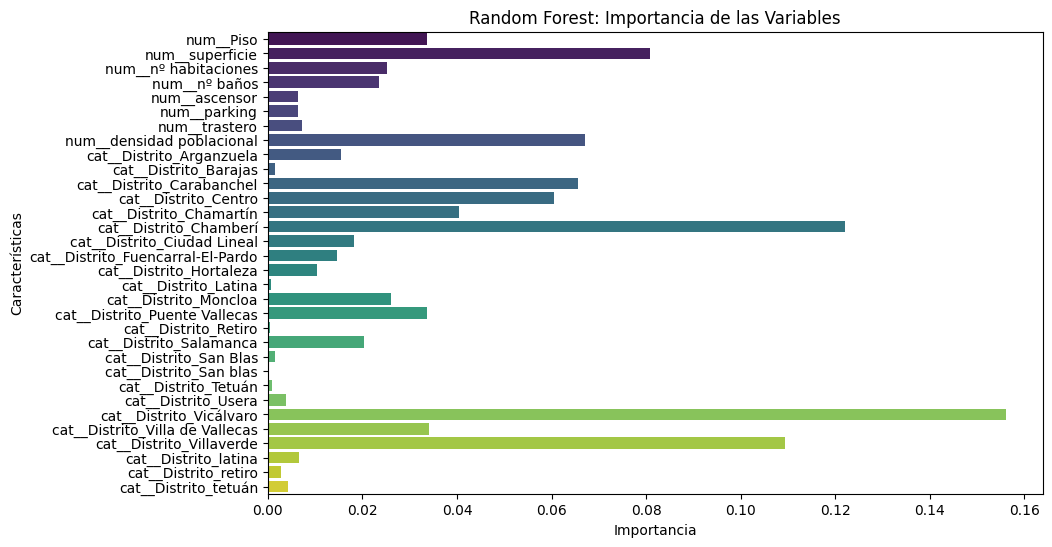

In [ ]:
# Definir variables predictoras y objetivo
X = df.drop(columns=["precio por m2", "precio", "fecha"])
y = df["precio por m2"]

# Identificar variables numéricas y categóricas
num_features = ["Piso", "superficie", "nº habitaciones", "nº baños", "ascensor", "parking", "trastero", "densidad poblacional"]
cat_features = ["Distrito"]

# Escalado para numéricas y one-hot encoding para categóricas
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Random Forest con hiperparámetros iniciales
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                                    min_samples_leaf=3, max_features=5, bootstrap=True,
                                    random_state=42))
])

# Entrenar modelo antes
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

# Evaluar modelo antes
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Evaluar sobreajuste o subajuste
y_train_pred = rf_pipeline.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

def detect_overfitting(r2_train, r2_test, threshold=0.1):
    if r2_train - r2_test > threshold:
        return "Posible Overfitting"
    elif r2_test > r2_train:
        return "Posible Underfitting"
    else:
        return "Buen Ajuste"

diagnostico = detect_overfitting(r2_train, r2_test)

print(f"\nDiagnóstico del Modelo:")
print(f"R² Entrenamiento: {r2_train:.4f}")
print(f"R² Prueba: {r2_test:.4f}")
print(f"Resultado: {diagnostico}")

#  Visualización Importancia de variables
rf_model = rf_pipeline.named_steps["model"]
importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Random Forest: Importancia de las Variables")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

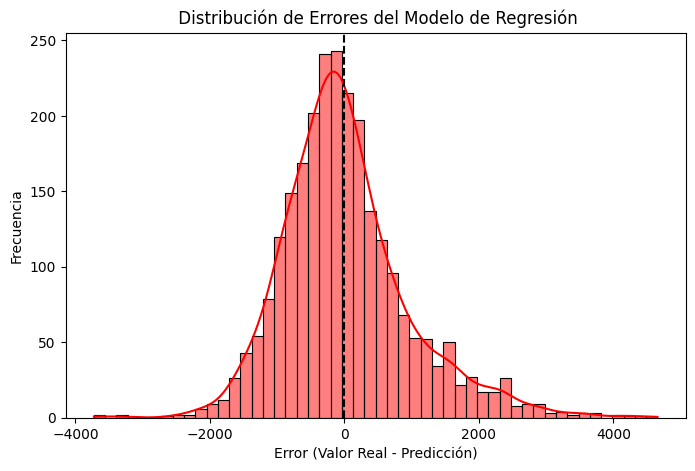

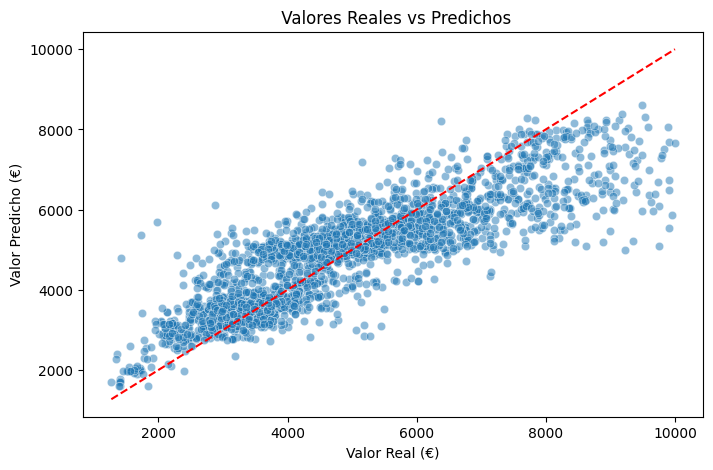

In [ ]:
#  GRÁFICO: Distribución de Errores
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color="red")
plt.axvline(0, color='black', linestyle='dashed')
plt.title(" Distribución de Errores del Modelo de Regresión")
plt.xlabel("Error (Valor Real - Predicción)")
plt.ylabel("Frecuencia")
plt.show()

#  GRÁFICO: Valores Predichos vs Reales
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.title(" Valores Reales vs Predichos")
plt.xlabel("Valor Real (€)")
plt.ylabel("Valor Predicho (€)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # Línea perfecta de predicción
plt.show()

In [ ]:
# GRID SEARCH
param_grid_rf = {
    "model__n_estimators": [100, 200, 300],  # Número de árboles en el bosque
    "model__max_depth": [10, 15, 20],  # Profundidad máxima de los árboles
    "model__min_samples_split": [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    "model__min_samples_leaf": [1, 3, 5],  # Número mínimo de muestras en una hoja
    "model__max_features": ["sqrt", "log2"]  # Número de características consideradas en cada división
}

# GridSearchCV mejores hiperparámetros
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring="r2", n_jobs=-1, verbose=2)

# Entrenar GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search_rf.best_params_
print("\n Mejores Hiperparámetros Encontrados:")
print(best_params)

# Reentrenar el modelo con los mejores hiperparámetros
rf_pipeline.set_params(**best_params)
rf_pipeline.fit(X_train, y_train)

# Evaluar modelo optimizado
y_pred_opt = rf_pipeline.predict(X_test)

mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\n Métricas del Modelo Optimizado:")
print(f" MAE (Error Absoluto Medio): {mae_opt:.2f} €")
print(f" RMSE (Error Cuadrático Medio): {rmse_opt:.2f} €")
print(f" R² (Coeficiente de Determinación): {r2_opt:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits

 Mejores Hiperparámetros Encontrados:
{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}

 Métricas del Modelo Optimizado:
 MAE (Error Absoluto Medio): 537.23 €
 RMSE (Error Cuadrático Medio): 767.59 €
 R² (Coeficiente de Determinación): 0.8206



 Métricas del Modelo DESPUÉS de Optimización:
 MAE (Error Absoluto Medio): 537.23 €
 RMSE (Error Cuadrático Medio): 767.59 €
 R² Entrenamiento: 0.9080
 R² Prueba: 0.8206

 Diagnóstico del Modelo DESPUÉS de Optimización:
 R² Entrenamiento: 0.9080
 R² Prueba: 0.8206
 Resultado: Buen Ajuste


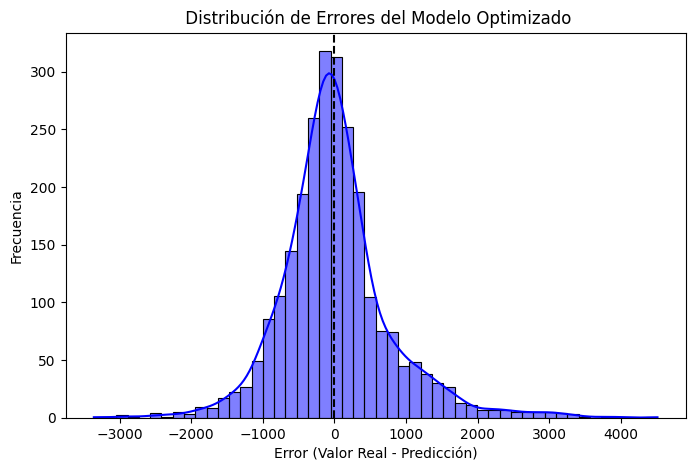

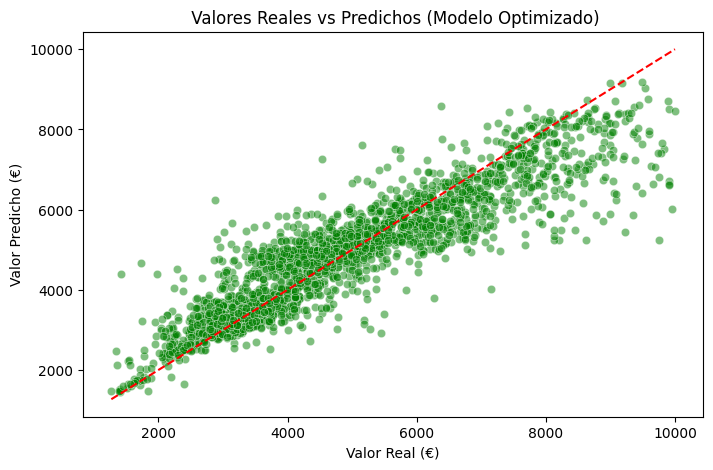

<ipython-input-6-2aa32a773ced>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_opt, y=feature_names_opt, palette="magma")


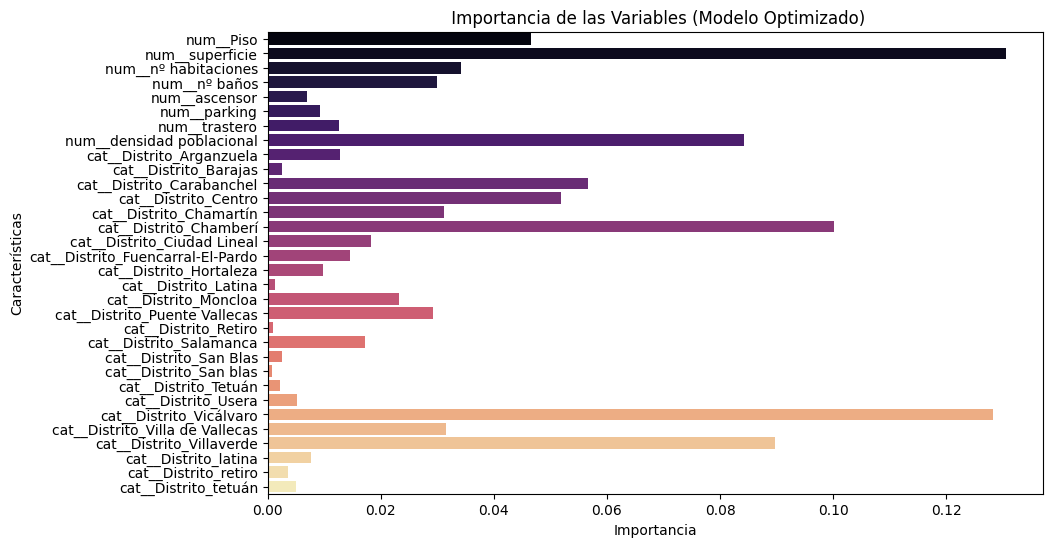

In [ ]:
#  **Evaluar modelo optimizado**
y_train_pred_opt = rf_pipeline.predict(X_train)  # Predicciones en entrenamiento
y_test_pred_opt = rf_pipeline.predict(X_test)  # Predicciones en prueba

mae_opt = mean_absolute_error(y_test, y_test_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))
r2_train_opt = r2_score(y_train, y_train_pred_opt)
r2_test_opt = r2_score(y_test, y_test_pred_opt)

print("\n Métricas del Modelo DESPUÉS de Optimización:")
print(f" MAE (Error Absoluto Medio): {mae_opt:.2f} €")
print(f" RMSE (Error Cuadrático Medio): {rmse_opt:.2f} €")
print(f" R² Entrenamiento: {r2_train_opt:.4f}")
print(f" R² Prueba: {r2_test_opt:.4f}")

#  **Evaluar sobreajuste o subajuste después de optimización**
diagnostico_opt = detect_overfitting(r2_train_opt, r2_test_opt)

print(f"\n Diagnóstico del Modelo DESPUÉS de Optimización:")
print(f" R² Entrenamiento: {r2_train_opt:.4f}")
print(f" R² Prueba: {r2_test_opt:.4f}")
print(f" Resultado: {diagnostico_opt}")

#  Nueva Distribución de Errores (Después de la Optimización)**
errors_opt = y_test - y_test_pred_opt
plt.figure(figsize=(8, 5))
sns.histplot(errors_opt, bins=50, kde=True, color="blue")
plt.axvline(0, color='black', linestyle='dashed')
plt.title(" Distribución de Errores del Modelo Optimizado")
plt.xlabel("Error (Valor Real - Predicción)")
plt.ylabel("Frecuencia")
plt.show()

#  Nuevos Valores Reales vs Predichos**
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_test_pred_opt, alpha=0.5, color="green")
plt.title(" Valores Reales vs Predichos (Modelo Optimizado)")
plt.xlabel("Valor Real (€)")
plt.ylabel("Valor Predicho (€)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

#  Nueva Importancia de las Variables**
rf_model_opt = rf_pipeline.named_steps["model"]
importances_opt = rf_model_opt.feature_importances_
feature_names_opt = preprocessor.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_opt, y=feature_names_opt, palette="magma")
plt.title(" Importancia de las Variables (Modelo Optimizado)")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()